In [1]:
import torch
from torch.utils.data import DataLoader
import mne
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from model import *
from dataset import *
from utils import *
from train import *

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
device

'cuda'

In [2]:
train_story_list = dict(
    Moth1=["souls", "avatar", "legacy", "odetostepfather"],
    Moth2=["howtodraw", "myfirstdaywiththeyankees", "naked", "life"],
    Moth3=["tildeath", "fromboyhoodtofatherhood", "sloth", "exorcism"],
    Moth4=["adollshouse", "inamoment", "theclosetthatateeverything", "adventuresinsayingyes", "haveyoumethimyet"],
    Moth5=["thatthingonmyarm", "eyespy", "itsabox", "hangtime"],
)
train_stories = [story for session in train_story_list.keys() for story in train_story_list[session]]
val_stories = [["swimmingwithastronauts1", "swimmingwithastronauts2"]]

In [3]:
# let test stories be all 27 stories
with open("data/story_to_uniquestory.pkl", "rb") as f:
    story_to_uniquestory = pickle.load(f)
test_stories = list(story_to_uniquestory.keys())
test_stories = [s for s in test_stories if s != "stimuli_auditory_localizer" and not s[-1] in ["2", "3", "4", "5"]]
test_stories

['alternateithicatom1',
 'souls',
 'wheretheressmoke1',
 'avatar',
 'legacy',
 'odetostepfather',
 'undertheinfluence1',
 'howtodraw',
 'myfirstdaywiththeyankees',
 'naked',
 'life',
 'stagefright1',
 'tildeath',
 'fromboyhoodtofatherhood',
 'sloth',
 'exorcism',
 'buck1',
 'adollshouse',
 'inamoment',
 'theclosetthatateeverything',
 'adventuresinsayingyes',
 'haveyoumethimyet',
 'swimmingwithastronauts1',
 'thatthingonmyarm',
 'eyespy',
 'itsabox',
 'hangtime']

In [4]:
# config
name = "WdPnFq-seg8-flexconv4-A"
which = "val-loss-min"
SAVEFIG = False

with open(f"config/{name}.yaml", "r") as f:
    config = yaml.safe_load(f)
MEG_SUBJECT = config["MEG_SUBJECT"]
FMRI_SUBJECT = config["FMRI_SUBJECT"]
use_segment = config["use_segment"]
spacing = config["spacing"]
meg_loss_weight = config["meg_loss_weight"]
fmri_loss_weight = config["fmri_loss_weight"]
softmax_T = config["softmax_T"]
dataset_params = config["dataset"]
model_params = config["model"]

## Dataset

In [5]:
train_dataset = StoryDataset(
    MEG_SUBJECT,
    FMRI_SUBJECT,
    train_stories[0:1],
    name=name,
    spacing=spacing,
    preload=False,
    **dataset_params,
)  # evalulate don't care this
val_dataset = StoryDataset(
    MEG_SUBJECT,
    FMRI_SUBJECT,
    val_stories,
    name=name,
    spacing=spacing,
    pca_meg=train_dataset.pca_meg,
    pca_mri=train_dataset.pca_mri,
    **dataset_params,
)
test_dataset = StoryDataset(
    MEG_SUBJECT,
    FMRI_SUBJECT,
    test_stories,
    name=name,
    spacing=spacing,
    pca_meg=train_dataset.pca_meg,
    pca_mri=train_dataset.pca_mri,
    MEG_DIR="moth_meg",
    **dataset_params,
)
embed_dim = test_dataset.embed_dim

use_word: True, use_phoneme: True, use_freq: True, use_meg: False, use_mri: False
embed_dim:  852
use_word: True, use_phoneme: True, use_freq: True, use_meg: False, use_mri: False
embed_dim:  852
Loading story swimmingwithastronauts1...


Finished loading story swimmingwithastronauts1!
Loading story swimmingwithastronauts2...
Finished loading story swimmingwithastronauts2!
Preloaded all stories!
use_word: True, use_phoneme: True, use_freq: True, use_meg: False, use_mri: False
embed_dim:  852
Loading story alternateithicatom1...
Finished loading story alternateithicatom1!
Loading story souls...
Finished loading story souls!
Loading story wheretheressmoke1...
Finished loading story wheretheressmoke1!
Loading story avatar...
Finished loading story avatar!
Loading story legacy...
Finished loading story legacy!
Loading story odetostepfather...
Finished loading story odetostepfather!
Loading story undertheinfluence1...
Finished loading story undertheinfluence1!
Loading story howtodraw...
Finished loading story howtodraw!
Loading story myfirstdaywiththeyankees...
Finished loading story myfirstdaywiththeyankees!
Loading story naked...
Finished loading story naked!
Loading story life...
Finished loading story life!
Loading story

## Lead Field

In [6]:
# load forward solution to get the lead field
fname_fwd = f"data/{MEG_SUBJECT}-{spacing}-fwd.fif"
fwd = mne.read_forward_solution(fname_fwd)
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True, use_cps=True)  # let's do fixed orientation
lead_field = fwd_fixed["sol"]["data"]
lead_field = torch.from_numpy(lead_field)
n_channels, n_neurons = lead_field.shape
n_channels, n_neurons

Reading forward solution from /home/yishuli/MEG-fMRI/data/A-oct6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


(306, 8196)

## Get Sources

In [7]:
model = TransformerSourceModel(
    embed_dim=embed_dim,
    lead_field=lead_field,
    **model_params,
).to(device)
ckpt_path = f"trained_models/{name}_{which}.pth"
info = load_checkpoint(ckpt_path, model, None, None, device=device)
print(info)

(68, 1.0055146501442056, 0.07546357089945342, 0.9299632706765684)


In [8]:
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    validate(
        model,
        val_dataloader,
        device,
        subject=MEG_SUBJECT,
        meg_loss_weight=meg_loss_weight,
        fmri_loss_weight=fmri_loss_weight,
        softmax_T=softmax_T,
    )

val_meg_loss: 0.07466866387896606, val_fmri_loss: 0.9308459862652395


In [9]:
model.eval()
meg_dict, meg_power_dict = {}, {}

for i in range(len(test_dataset)):
    # load data
    embeds, _, _ = test_dataset[i]
    embeds = embeds.to(device)
    # foward pass
    with torch.no_grad():
        _, meg_pred, _ = model(embeds.unsqueeze(0))
        meg_pred = meg_pred.squeeze(0).detach().cpu()
        # calculate power
        meg_pred_power = hilbert_torch(meg_pred, dim=0)
        meg_pred_power = meg_pred_power.abs()
        meg_pred_power.pow_(2)
        # zscore
        meg_pred = zscore_tensor(torch.abs(meg_pred), dim=0).numpy()
        meg_pred_power = zscore_tensor(meg_pred_power, dim=0).numpy()
    meg_dict[test_stories[i]] = meg_pred
    meg_power_dict[test_stories[i]] = meg_pred_power
    # save memory
    del embeds
    torch.cuda.empty_cache()

## Load Surprisal

In [10]:
# load grid transcript
with open("data/moth_word_surprisal_context20.pkl", "rb") as fp:
    story_word_surprisal_dict = pickle.load(fp)

In [11]:
all_surprisals = []
for story in story_word_surprisal_dict.keys():
    story_word_surprisal = story_word_surprisal_dict[story]
    all_surprisals.extend([t[-2] for t in story_word_surprisal])

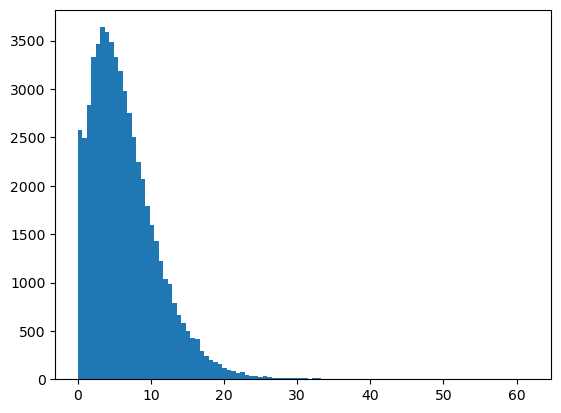

In [12]:
# plot a histogram of the surprisal
plt.hist(all_surprisals, bins=100)
plt.show()

## Get Word Response

In [13]:
# loading textgrids
words = dict()
word_onset = dict()
word_surprisal = dict()
DEFAULT_BAD_WORDS = ["sentence_start", "sentence_end", "{SL}", "{{BR}", "{BR}", "(BR}", "{BR", "{LG}", "{ls}", "{LS}", "{IG}", "{CG}", "{LS)", "{NS}", "{NS_AP}", "{SP}", "sp", "", " "]
content_pos = ["NOUN"]

for this_story in test_stories:
    this_story_unique = story_to_uniquestory[this_story]
    story_word_surprisal = story_word_surprisal_dict[this_story_unique]
    # correct delay
    time_features = [tuple([float(t[0]), float(t[1])] + list(t[2:])) for t in story_word_surprisal]
    time_features_corrected = get_stretched_features(time_features, MEG_SUBJECT, None, None, use_mean_rate=True)
    words_this_story, word_onset_this_story, word_surprisal_this_story = [], [], []
    for t in time_features_corrected:
        if t[2] in DEFAULT_BAD_WORDS or t[-1] not in content_pos:
            continue
        else:
            word_onset_this_story.append(float(t[0]))
            words_this_story.append(t[2])
            word_surprisal_this_story.append(float(t[-2]))
    words[this_story] = words_this_story
    word_onset[this_story] = np.array(word_onset_this_story)
    word_surprisal[this_story] = np.array(word_surprisal_this_story)

del story_word_surprisal_dict, story_word_surprisal, time_features, time_features_corrected

## Get Correlation

In [14]:
# define lags
sfreq = 50
step = int(1000 / sfreq)  # 20ms
lag_sample_start = -10
lag_sample_end = 50
lag_samples = np.arange(lag_sample_start, lag_sample_end + 1)
lags = lag_samples * step

In [15]:
# get neuron response for each word onset
meg_onset, meg_power_onset = [], []
surprisals = []
for story in test_stories:
    word_onset_story = word_onset[story]
    word_surprisal_story = word_surprisal[story]
    neurons_story = meg_dict[story]
    neurons_power_story = meg_power_dict[story]
    for t, s in zip(word_onset_story, word_surprisal_story):
        t_sample = int(t * 50)
        t_sample_start = t_sample + lag_sample_start
        t_sample_end = t_sample + lag_sample_end + 1
        if t_sample_start > 0 and t_sample_end < neurons_power_story.shape[0]:
            meg_onset.append(neurons_story[t_sample_start:t_sample_end, :])
            meg_power_onset.append(neurons_power_story[t_sample_start:t_sample_end, :])
            surprisals.append(s)
meg_onset = np.stack(meg_onset)
meg_power_onset = np.stack(meg_power_onset)
surprisals = np.array(surprisals)

In [16]:
meg_onset.shape, meg_power_onset.shape, surprisals.shape

((13627, 61, 306), (13627, 61, 306), (13627,))

In [17]:
del meg_dict, meg_power_dict

In [18]:
# correlate surprisal with neuron response (torch)
surprisals_z = zscore_tensor(torch.from_numpy(surprisals), dim=0)
meg_onset_z = zscore_tensor(torch.from_numpy(meg_onset), dim=0)
meg_onset_corrs = meg_onset_z * surprisals_z[:, None, None]
meg_onset_corrs = torch.mean(meg_onset_corrs, dim=0).numpy()
meg_power_onset_z = zscore_tensor(torch.from_numpy(meg_power_onset), dim=0)
meg_power_onset_corrs = meg_power_onset_z * surprisals_z[:, None, None]
meg_power_onset_corrs = torch.mean(meg_power_onset_corrs, dim=0).numpy()

In [19]:
lobe_masks_dict = np.load("data/channel_lobe_masks.npy", allow_pickle=True).item()
L_temporal_mask = lobe_masks_dict["L_temporal"].flatten().astype(bool)
R_temporal_mask = lobe_masks_dict["R_temporal"].flatten().astype(bool)
L_frontal_mask = lobe_masks_dict["L_frontal"].flatten().astype(bool)

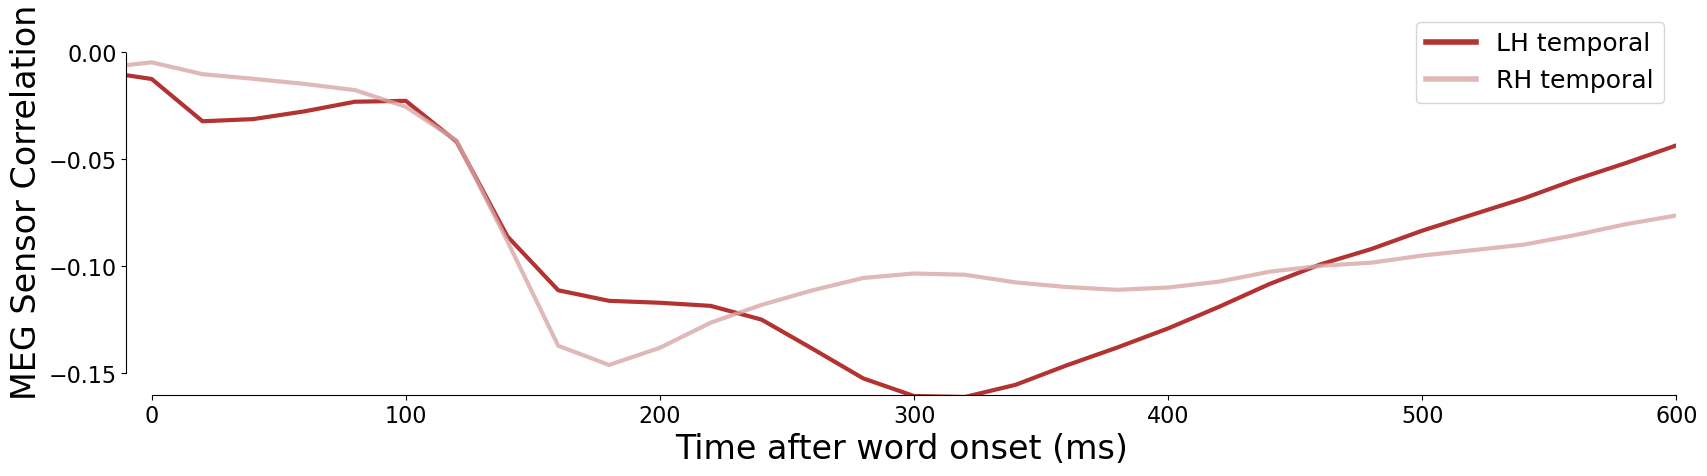

In [20]:
fig, ax = plt.subplots(figsize=(20, 5))

# your two curves
ax.plot(lags, meg_onset_corrs[:, L_temporal_mask].mean(axis=1), lw=3, color="#a00000", label="LH temporal", alpha=0.8)
ax.plot(lags, meg_onset_corrs[:, R_temporal_mask].mean(axis=1), lw=3, color="#d8a6a6", label="RH temporal", alpha=0.8)

# labels & ticks
ax.set_xlabel("Time after word onset (ms)", fontsize=24)
ax.set_ylabel("MEG Sensor Correlation", fontsize=24)
ax.tick_params(axis="x", labelsize=16)
ax.set_xticks(np.arange(0, 601, 100))
ax.set_yticks(np.arange(-0.15, 0.01, 0.05))
ax.tick_params(axis="y", labelsize=16)

# hide the top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# set the y‐limits first
ax.set_ylim(-0.16, 0.02)
ax.set_xlim(-10, 600)
ax.spines["left"].set_bounds(-0.15, 0)
ax.spines["bottom"].set_bounds(0, 600)

# up‐size the legend
leg = ax.legend(
    fontsize=18,  # larger text
    markerscale=1,  # no markers here, but keeps spacing
    handlelength=2,  # make the little line segments longer
)
for line in leg.get_lines():
    line.set_linewidth(4)  # make legend lines thicker

if SAVEFIG:
    plt.savefig(f"figures/{MEG_SUBJECT}/suprisal_pred_meg.png", dpi=300, bbox_inches="tight")
plt.show()